In [1]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
from keras.utils.vis_utils import plot_model
import imutils
from google.colab.patches import cv2_imshow
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import tensorflow_addons as tfa
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# image directory path
image_path = '/content/drive/MyDrive/Applied AI/Deep Learning/Assignment/images'

In [5]:
# label directory path
label_path = '/content/drive/MyDrive/Applied AI/Deep Learning/Assignment/labels'

In [6]:
# images with truth label directory path
image_truth_path = '/content/drive/MyDrive/Applied AI/Deep Learning/Assignment/images_bb'

In [7]:
# function to get file names from a directory
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [8]:
# get a list of image files
img_list = getListOfFiles(image_path)
img_list_bb = getListOfFiles(image_truth_path)

In [9]:
random.seed(100)
random.shuffle(img_list)

In [10]:
img_array = []

In [11]:
label_array = []

In [12]:
# for loop to add bounding boxes to images
for img_file in img_list:
  img_file_decode = os.fsdecode(img_file)

  # open and read label file
  label_file = img_file_decode.replace('images', 'labels').replace('jpg', 'txt')
  label_file_open = open(label_file)
  label_file_content = label_file_open.read()
  label_file_coord = np.float_(label_file_content.split())[1:]

  #define rectangle patch
  rect = patches.Rectangle((label_file_coord[0], label_file_coord[1]), label_file_coord[2], label_file_coord[3], linewidth = 1, edgecolor = 'r', facecolor='none')
  
  # open image, get h, w
  image = cv2.imread(img_file)
  (h,w) = image.shape[:2]

  # plot bounding boxes and save image
  fig,ax = plt.subplots()
  ax.imshow(image)
  ax.add_patch(rect)
  bb_image_dir = img_file_decode.replace('images', 'images_bb')
  #plt.savefig(bb_image_dir)
  plt.close()

  # resize image, normalise scale and convert to array
  image = load_img(img_file, target_size=(224, 224))
  #image = cv2.resize(cv2.imread(img_file), (224,224))
  image = img_to_array(image)/255.0
  img_array.append(image)

  # append scaled bounding boxes to label array

  StartX = label_file_coord[0]/w
  StartY = label_file_coord[1]/h
  EndX = (label_file_coord[2] + label_file_coord[0])/w
  EndY = (label_file_coord[3] + label_file_coord[1])/h

  label_array.append(np.array([StartX, StartY, EndX, EndY]))

In [13]:
X = img_array
y = label_array

In [14]:
X_train = X[:260]
X_test = X[260:]
y_train = y[:260]
y_test = y[260:]

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
img_list_test = img_list[260:]

In [18]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58900480/58889256 [==============================] - 1s 0us/step


In [19]:
optimizer=Adam(learning_rate=.0001)

In [20]:
model.compile(optimizer=optimizer,
              loss = 'mse', metrics =  tfa.losses.GIoULoss())

In [21]:
early_stopping_monitor = EarlyStopping(patience=4, restore_best_weights=True)

In [22]:
training = model.fit(X_train, y_train, validation_split=0.15, epochs=60, batch_size=32, callbacks=[early_stopping_monitor])

Epoch 1/60
7/7 [==============================] - 33s 2s/step - loss: 0.0309 - giou_loss: 0.6920 - val_loss: 0.0212 - val_giou_loss: 0.7393
Epoch 2/60
7/7 [==============================] - 2s 298ms/step - loss: 0.0149 - giou_loss: 0.5792 - val_loss: 0.0189 - val_giou_loss: 0.6668
Epoch 3/60
7/7 [==============================] - 2s 300ms/step - loss: 0.0119 - giou_loss: 0.5255 - val_loss: 0.0150 - val_giou_loss: 0.6451
Epoch 4/60
7/7 [==============================] - 2s 299ms/step - loss: 0.0097 - giou_loss: 0.4901 - val_loss: 0.0136 - val_giou_loss: 0.6281
Epoch 5/60
7/7 [==============================] - 2s 290ms/step - loss: 0.0084 - giou_loss: 0.4692 - val_loss: 0.0138 - val_giou_loss: 0.6424
Epoch 6/60
7/7 [==============================] - 2s 301ms/step - loss: 0.0069 - giou_loss: 0.4356 - val_loss: 0.0124 - val_giou_loss: 0.5801
Epoch 7/60
7/7 [==============================] - 2s 288ms/step - loss: 0.0058 - giou_loss: 0.3944 - val_loss: 0.0125 - val_giou_loss: 0.6077
Epoch 8/

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred[0][1]

0.29764545

In [25]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 204ms/step - loss: 0.0083 - giou_loss: 0.4656


[0.008310106582939625, 0.46561968326568604]

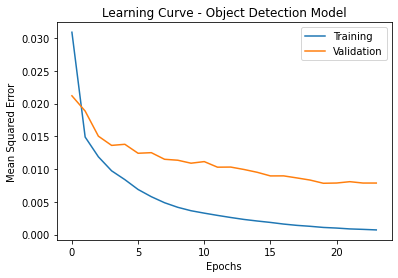

In [26]:
# Extract the history from the training object
history = training.history

# Plot the training loss 
plt.plot(history['loss'], label='Training')
# Plot the validation loss
plt.plot(history['val_loss'], label = 'Validation')

plt.title('Learning Curve - Object Detection Model')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

# Show the figure
plt.legend()
plt.show()

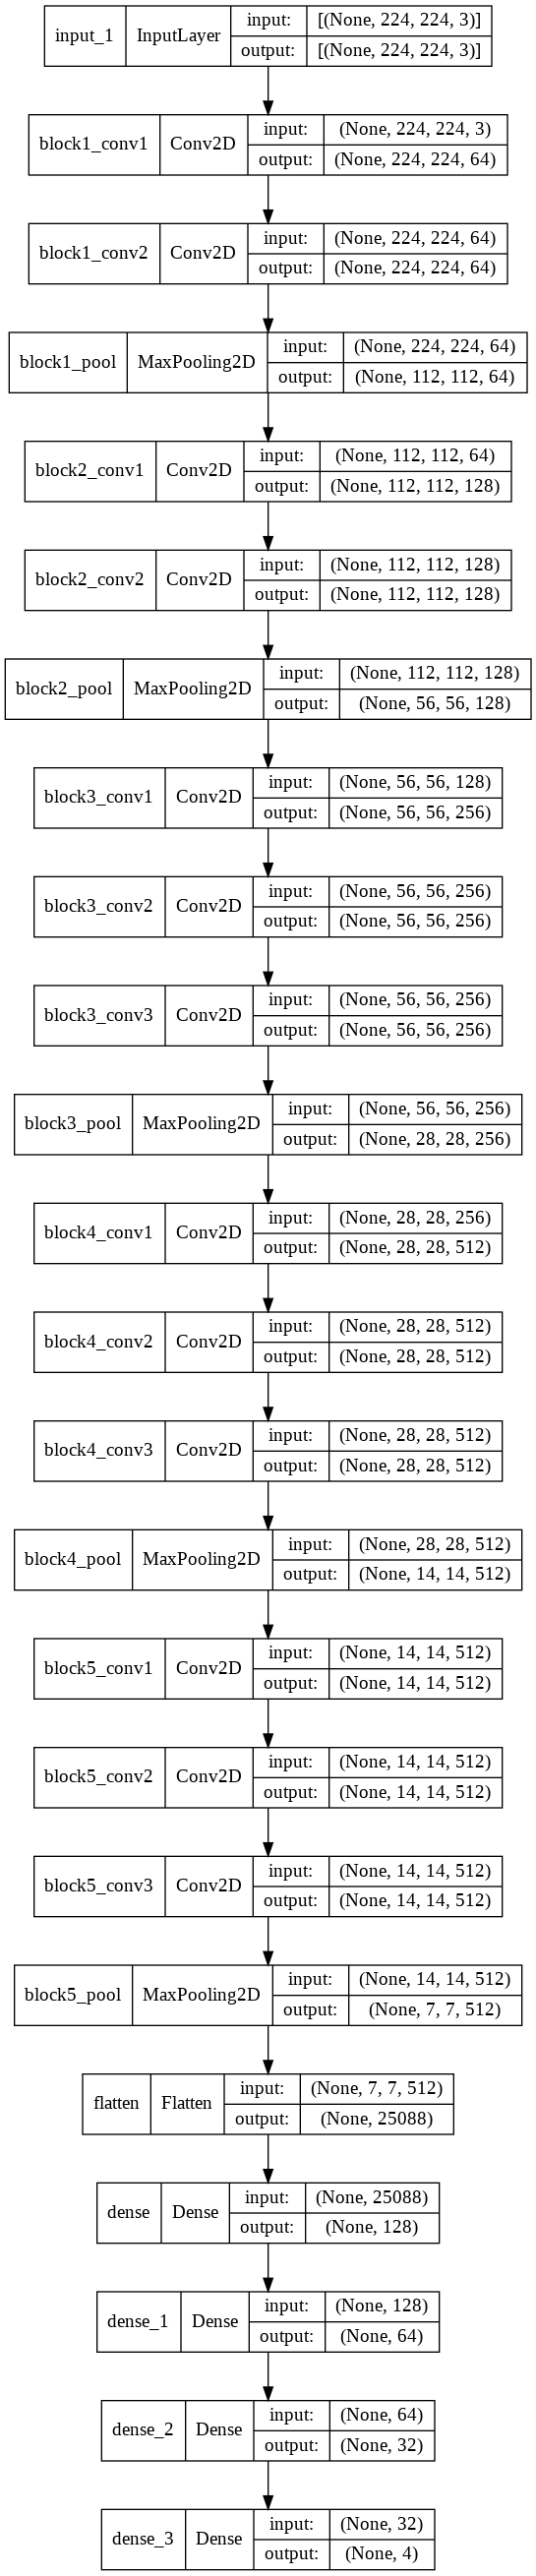

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [28]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [29]:
iou_list=[]

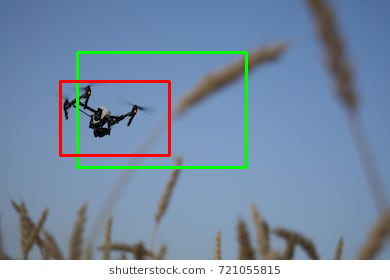

0.3290001449765621

In [30]:
index=2
img_file = img_list_test[index]
  
label_file = img_file_decode.replace('images', 'labels').replace('jpg', 'txt')
label_file_open = open(label_file)
label_file_content = label_file_open.read()
label_file_coord = np.float_(label_file_content.split())[1:]

image = cv2.imread(img_file)
#image = imutils.resize(image, width=600)
(h,w) = image.shape[:2]

startX_pred = int(y_pred[index][0] * w)
startY_pred = int(y_pred[index][1] * h)
endX_pred = int(y_pred[index][2]*w)
endY_pred = int(y_pred[index][3] * h)

startX = int(y_test[index][0]*w)
startY = int(y_test[index][1]*h)
endX = int(y_test[index][2]*w)
endY = int(y_test[index][3]*h)

cv2.rectangle(image, (startX_pred, startY_pred), (endX_pred, endY_pred),(0, 255, 0), 2)
cv2.rectangle(image, (startX , startY), (endX, endY),(0, 0, 255), 2)
cv2_imshow(image)

box1 = [startX_pred, startY_pred, endX_pred, endY_pred]
box2 = [startX, startY, endX, endY]

bb_intersection_over_union(box1, box2)


In [31]:
for index in range(len(X_test)):
  img_file = img_list_test[index]
  
  image = cv2.imread(img_file)
  (h,w) = image.shape[:2]

  startX_pred = int(y_pred[index][0] * w)
  startY_pred = int(y_pred[index][1] * h)
  endX_pred = int(y_pred[index][2]*w)
  endY_pred = int(y_pred[index][3] * h)

  startX = int(y_test[index][0]*w)
  startY = int(y_test[index][1]*h)
  endX = int(y_test[index][2]*w)
  endY = int(y_test[index][3]*h)

  cv2.rectangle(image, (startX_pred, startY_pred), (endX_pred, endY_pred),(0, 255, 0), 2)
  cv2.rectangle(image, (startX , startY), (endX, endY),(0, 0, 255), 2)
  cv2_imshow(image)

  box1 = [startX_pred, startY_pred, endX_pred, endY_pred]
  box2 = [startX, startY, endX, endY]

  iou = bb_intersection_over_union(box1, box2)
  iou_list.append(iou)


In [32]:
avg_iou = sum(iou_list)/len(iou_list)
avg_iou

0.5932311774454712

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


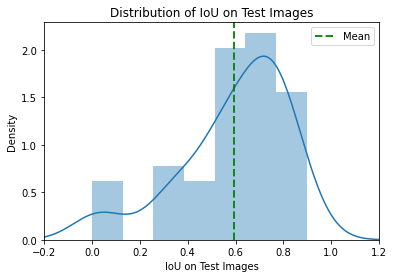

In [33]:
sns.distplot(iou_list)
plt.xlabel('IoU on Test Images')
plt.xlim(-0.2, 1.2)
plt.title('Distribution of IoU on Test Images')
plt.axvline(x=np.mean(iou_list), linewidth=2, color='g', label="Mean", linestyle = '--', alpha=0.9)
plt.legend()